In [1]:
import os, math, sys
from sys import stdout

import numpy as np
import matplotlib.pyplot as plt
import openmm.app  as omm_app
import openmm as omm
import simtk.unit as unit
from tqdm import tqdm

import torch.nn as nn
import torch
# import openmmtools
from openmmtorch import TorchForce
from copy import deepcopy
import MDAnalysis as mda
from MDAnalysis.analysis import align, rms

/export/ssule25/miniconda3/envs/ptorch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/export/ssule25/miniconda3/envs/ptorch/lib/python3.11/site-packages/Bio/Application/__init__.py:40: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


In [2]:
from MDAnalysis.analysis.dihedrals import Dihedral

We will now compute the diffusion tensor for each point in a metadynamics simulation. The relevant dcd file is given by `traj_metad_apr2.dcd`. The method we will use will be the spring constant method in Van den eijnden, Ciccotti et al. 

### Citing: Most of the openmm data needed for butane and format of this notebook comes from [here](https://fastmbar.readthedocs.io/en/latest/butane_PMF.html).

In [3]:
# Indicates whether to run a simulation or not
SIMULATE = False
device = "cpu"

## 1. Construct an OpenMM system of butane
We set up the MD molecular system in the format/object required by OpenMM, a class called
[System](http://docs.openmm.org/7.1.0/api-python/generated/simtk.openmm.openmm.System.html).

We read in **psf** and **pdb** files for butane: butane.psf and butane.pdb.
The psf file, butane.psf, contains the topology of butane and it is the topolgy file format used by [CHARMM](https://www.charmm.org/).
The file used here is generated using CHARMM.
OpenMM has parsers for topology files with different format from AMBER, CHARMM, etc.

In [4]:
psf = omm_app.CharmmPsfFile('../data/butane.psf')
pdb = omm_app.PDBFile('../data/butane.pdb')
topology = psf.topology

Read CHARMM force field for butane. The CHARMM force field is downloaded from [here](http://mackerell.umaryland.edu/charmm_ff.shtml)

In [5]:
params = omm_app.CharmmParameterSet('../data/top_all35_ethers.rtf',
                                    '../data/par_all35_ethers.prm')

Create a OpenMM system based on the psf file of butane and the CHARMM force field.

In [6]:
system = psf.createSystem(params, nonbondedMethod=omm_app.NoCutoff)

After constructing the OpenMM system of butane, we can save it in an XML formated text file, which can be used later for simulations. Therefore, if we want to use the same system in another script, we can just read the text file in an OpenMM system instead of constructing it again. This file is a readable text file and can be used to see what system information is used.

In [7]:
with open("../output/system.xml", 'w') as file_handle:
    file_handle.write(omm.XmlSerializer.serialize(system))

In [8]:
## read the OpenMM system of butane
with open("../output/system.xml", 'r') as file_handle:
    xml = file_handle.read()
system = omm.XmlSerializer.deserialize(xml)

## read psf and pdb file of butane
psf = omm_app.CharmmPsfFile("../data/butane.psf")
pdb = omm_app.PDBFile('../data/butane.pdb')
topology = psf.topology

# 1.a Set up biased sampling

In [247]:
class CollectiveVars(nn.Module):
    def __init__(self, activation, input_dim, hidden1_dim, hidden2_dim, encoder_dim):
        super(CollectiveVars, self).__init__()
        
        # Defining the layers of the neural network
        self.activation = activation
        self.hidden1 = nn.Linear(input_dim, hidden1_dim)
        
        self.hidden2 = nn.Linear(hidden1_dim, hidden2_dim)
        self.bottleneck = nn.Linear(hidden2_dim, encoder_dim)

        # Collecting layers for convenience as encoder and decoder
        self.Psif = nn.Sequential(self.hidden1, self.activation, self.hidden2, self.activation, self.bottleneck, nn.GELU())
        
    def Psi(self, x):
        # print(x.device)
        return self.Psif(x)
    
    # Required for any subclass of nn.module: defines how data passes through the `computational graph'
    def forward(self, x):
        return self.Psi(x)
        
activation = nn.ELU(alpha=5.0) 
input_dim = 16
hidden1_dim = 32 # 45
hidden2_dim = 32
output_dim = 2 
# output_dim = 2



model_CV_dihedral = CollectiveVars(activation, input_dim, hidden1_dim, hidden2_dim, output_dim)
model_CV_dihedral.load_state_dict(torch.load('model_CV_carbon_pretrained_7jul24', map_location='cpu'))
model_CV_dihedral.eval()

# freeze the model
for param in model_CV_dihedral.parameters():
    param.requires_grad = False

In [ ]:
# #  this network has not been tuned effectively and hence further adjustments should be made to improve performance
# class CollectiveVarsDihedrals(nn.Module):
#     def __init__(self, activation, input_dim, hidden1_dim, hidden2_dim, encoder_dim):
#         super(CollectiveVarsDihedrals, self).__init__()
        
#         # Defining the layers of the neural network
#         self.activation = activation
#         self.hidden1 = nn.Linear(input_dim, hidden1_dim)
#         self.hidden2 = nn.Linear(hidden1_dim, hidden2_dim)
#         self.bottleneck = nn.Linear(hidden2_dim, encoder_dim)

#         # Collecting layers for convenience as encoder and decoder
#         self.Psif = nn.Sequential(self.hidden1, self.activation, self.hidden2, self.activation, self.bottleneck, nn.Tanh())
        
#     def Psi(self, x):
#         return self.Psif(x)
    
#     def forward(self, x):
#         return self.Psi(x)
        
# activation = nn.ELU(alpha=0.5) 
# input_dim = 12
# hidden1_dim = 45
# hidden2_dim = 50
# output_dim = 2
# model_CV_dihedral = CollectiveVarsDihedrals(activation,\
#                                             input_dim, \
#                                             hidden1_dim, hidden2_dim, output_dim)
# model_CV_dihedral.load_state_dict(torch.load('model_CV_14thaug.zip'))
# model_CV_dihedral.eval()

# # freeze the model
# for param in model_CV_dihedral.parameters():
#     param.requires_grad = False


In [248]:
carbon_inds = [3,6,9,13]
mask = torch.zeros(14, dtype=torch.bool)
for i in carbon_inds: 
    mask[i] = True

def compute_gram_matrix_recentered(x):
    # n_atoms = int(x.shape[0]/3)
    # coords = x.reshape((n_atoms,3))
    rescaled_coords = x - torch.mean(x,dim=0).reshape(1,3)
    gram = torch.matmul(rescaled_coords, rescaled_coords.T)
    return gram.flatten()

In [249]:
class CV_test(nn.Module):
    def __init__(self, atomic_numbers, idx, mask, single):

        super().__init__()
        carbon_inds = np.array([3,6,9,13])
        self.mask = mask
        # self.mask = nn.Linear(14,4)
        self.CV = deepcopy(model_CV_dihedral)
        self.idx = idx
        # for i in range(4): 
        #     self.mask[i,carbon_inds[i]] = 1.0
        if single:
            self.m = nn.Flatten(0,-1)
        else:
            self.m = nn.Flatten(1,-1)
        # Store the atomic numbers
        # self.Linear1 = nn.Linear(atomic_numbers, 1)
        # self.act = nn.ELU()

    def forward(self, positions):
        # print(f"{positions.shape}")
        # carbons = positions[mask,:]
        # carbons = torch.matmul(mask,positions)
        # print(f"{positions.device}")
        # print(f"{self.mask.device}")
        carbons = 10*positions[self.mask, :]
        gram_matrix = compute_gram_matrix_recentered(carbons)
        # flat = self.m(gram_matrix)
        # h = self.Linear1(flat)
        h = self.CV(gram_matrix.float())
        return h[self.idx]

In [ ]:
cv_model_1 = CV_test(12, 0, mask, single = True)
cv_model_2 = CV_test(12, 1, mask, single = True)

In [ ]:
cv_model_1.to(device)
cv_model_2.to(device)
cv1 = torch.jit.script(cv_model_1)
cv2 = torch.jit.script(cv_model_2)
CV_force_1 = TorchForce(cv1)
CV_force_2 = TorchForce(cv2)

In [ ]:
cv_1 = omm.CustomCVForce("cv1")
cv_1.addCollectiveVariable("cv1",CV_force_1)

cv_2 = omm.CustomCVForce("cv2")
cv_2.addCollectiveVariable("cv2",CV_force_2)

## add a harmonic biasing potential on butane dihedral to the OpenMM system
# bias_cv = omm.CustomCVForce('0.5*Kappa*((theta1 - x1)^2 + (theta2 - x2)^2)')
bias_cv = omm.CustomCVForce('0.5*Kappa*((theta2 - x2)^2)')
bias_cv.addGlobalParameter("Kappa", 500.0)
# bias_cv.addGlobalParameter("x1", 0.0)
bias_cv.addGlobalParameter("x2", 0.9)
# bias_cv.addCollectiveVariable('theta1',cv_1)
bias_cv.addCollectiveVariable("theta2",cv_2)
system.addForce(bias_cv)

# 1b. Dnet-based CV

In [9]:
device = 'cpu'

In [10]:
from models_features import Encoder_deep, recenter_bond_torch

In [11]:
# this defines the structure of the model
activation = nn.Tanh() 
input_dim = 12
hidden1_dim = 32
hidden2_dim = 32
hidden3_dim = 32
hidden4_dim = 32
encoder_dim = 2
output_dim = 12
model_encoder_reg = Encoder_deep(activation, input_dim, hidden1_dim, hidden2_dim, hidden3_dim, hidden4_dim, encoder_dim).to(device)
model_encoder_reg.load_state_dict(torch.load("model_encoder_DNet_Laplacian_12sep2024_carbons", map_location=device))
model_encoder_reg.eval()

Encoder_deep(
  (activation): Tanh()
  (hidden1): Linear(in_features=12, out_features=32, bias=True)
  (hidden2): Linear(in_features=32, out_features=32, bias=True)
  (hidden3): Linear(in_features=32, out_features=32, bias=True)
  (hidden4): Linear(in_features=32, out_features=32, bias=True)
  (bottleneck): Linear(in_features=32, out_features=2, bias=True)
  (encoder): Sequential(
    (0): Linear(in_features=12, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Tanh()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): Tanh()
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): Tanh()
    (8): Linear(in_features=32, out_features=2, bias=True)
    (9): Tanh()
  )
)

In [12]:
carbon_inds = [3,6,9,13]
mask = torch.zeros(14, dtype=torch.bool)
for i in carbon_inds: 
    mask[i] = True   
class collective_variable(nn.Module):
    def __init__(self, mask, featurizer, Dnet): 
        super().__init__()
        self.mask = mask
        self.featurizer = featurizer
        self.Dnet = Dnet
    def forward(self,x):
        x = 10*x[self.mask, :]
        x = self.featurizer(x) 
        x = self.Dnet(x.float())
        return torch.norm(x)**2

In [13]:
cv_model_2 = collective_variable(mask, recenter_bond_torch, model_encoder_reg)

In [14]:
# cv_model_1.to(device)
# cv_model_2.to(device)
# cv1 = torch.jit.script(cv_model_1)
cv2 = torch.jit.script(cv_model_2)
# CV_force_1 = TorchForce(cv1)
CV_force_2 = TorchForce(cv2)

In [15]:
# cv_1 = omm.CustomCVForce("cv1")
# cv_1.addCollectiveVariable("cv1",CV_force_1)

cv_2 = omm.CustomCVForce("cv2")
cv_2.addCollectiveVariable("cv2",CV_force_2)

## add a harmonic biasing potential on butane dihedral to the OpenMM system
# bias_cv = omm.CustomCVForce('0.5*Kappa*((theta1 - x1)^2 + (theta2 - x2)^2)')
# bias_cv = omm.CustomCVForce('0.5*Kappa*((theta2 - x2)^2)')
bias_cv = omm.CustomCVForce('0.5*Kappa*diff^2; diff=abs(theta2 - x2)')
bias_cv.addGlobalParameter("Kappa", 500.0)
# bias_cv.addGlobalParameter("x1", 0.0)
bias_cv.addGlobalParameter("x2", 0.0)
# bias_cv.addCollectiveVariable('theta1',cv_1)
bias_cv.addCollectiveVariable("theta2",cv_2)
system.addForce(bias_cv)

8

# 2. Set up and get data

First we get the parameters of the system

In [34]:
#### setup an OpenMM context

## platform
platform = omm.Platform.getPlatformByName('CPU')

## integrator
# T = 298.15 * unit.kelvin  ## temperature
T = 300 * unit.kelvin
kbT = unit.BOLTZMANN_CONSTANT_kB * T * unit.AVOGADRO_CONSTANT_NA 
kbT = kbT.value_in_unit(unit.kilojoule_per_mole)

kbT_roomtemp = unit.BOLTZMANN_CONSTANT_kB*unit.AVOGADRO_CONSTANT_NA*300.0*unit.kelvin
kbT_roomtemp = kbT_roomtemp.value_in_unit(unit.kilojoule_per_mole)


## integrator
fricCoef = 10/unit.picoseconds ## friction coefficient 
# stepsize = 2 * unit.femtoseconds ## integration step size
stepsize = 1 * unit.femtoseconds
integrator = omm.LangevinMiddleIntegrator(T, fricCoef, stepsize)

## construct an OpenMM context
# context = omm.Context(system, integrator, platform)
simulation = omm_app.Simulation(topology, system, integrator, platform)

# M = 5
# x1 = np.linspace(-1, 1, M, endpoint = False)

# 2b. Get saved data

In [254]:
data_dic = dict(np.load(f"../output/traj_current/jul15_1dCV/sim16/butane_metad_carbons_jul9.npz", allow_pickle=True))
data_CV = data_dic['dataCV']
free_energy = data_dic['free_energy'].item()
evaluation_points = free_energy['evaluation points']

Next we get data via `mdtraj`

In [21]:
mobile = mda.Universe("../data/butane.psf", "../output/traj_current/traj_metad_aug1.dcd")
trajectory = torch.Tensor(mobile.trajectory.timeseries(mobile.atoms))

/export/ssule25/miniconda3/envs/ptorch/lib/python3.11/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"
/export/ssule25/miniconda3/envs/ptorch/lib/python3.11/site-packages/MDAnalysis/coordinates/DCD.py:326: DeprecationWarning: asel argument to timeseries will be renamed to'atomgroup' in 3.0, see #3911
  warnings.warn(


# 2c. Alternative: generate CV data

In [22]:
cv_model_2.eval()
data_CV = torch.zeros((len(mobile.trajectory), 1))
trajectory = torch.Tensor(mobile.trajectory.timeseries(mobile.atoms)).to(device)
for i in tqdm(range(len(mobile.trajectory))):
    # mobile.trajectory[i]
    x = trajectory[:,i,:]
    # x = torch.tensor(mobile.atoms.positions, dtype=torch.float64).to(device)
    # print(f"{x[0,0]}")
    # print(f"cv 1: {cv_model_1(x)}, cv 2: {cv_model_2(x)}")
    # data[i,0] = cv_model_1(0.1*x) # multiply the input point by 0.1 because the DCD files are all in 10nm. 
    data_CV[i,0] = cv_model_2(0.1*x)
    # print(f"CV 1: {cv_model_1(x)}, CV 2:  {cv_model_2(x)}")
data_CV = data_CV.detach().numpy()
evaluation_points = np.linspace(0.0,0.03,1000)

100%|█████████████████████████████████████| 4707/4707 [00:02<00:00, 2192.22it/s]


## Detour: construct dihedrals

In [ ]:
dihedrals = np.loadtxt( f"../output/traj_current/dihedral_metad_apr2.csv", delimiter = ",")

# shift dihedrals from [-pi, pi] to [0, 2pi]
dihedrals[dihedrals < 0] = dihedrals[dihedrals < 0] + 2*np.pi

_ = plt.hist(dihedrals, bins=50, density=True)

In [ ]:
step = 10
data = torch.zeros((len(mobile.trajectory)//step, 2))
angles = torch.zeros((len(mobile.trajectory)//step, 1))
indices = []
N_samples = len(mobile.trajectory)//step
for i in tqdm(range(data.shape[0])):
    mobile.trajectory[step*i]
    indices.append(step*i)
    x = torch.tensor(mobile.atoms.positions, dtype=torch.float64).to(device)
    data[i,0] = cv_model_1(0.1*x) # multiply the input point by 0.1 because the DCD files are all in 10nm. 
    data[i,1] = cv_model_2(0.1*x)
    angles[i] = dihedrals[step*i]

In [ ]:
# # subsample for new data
# N_samples=10
# idx = np.round(np.linspace(0, data.shape[0]-1, N_samples)).astype(int)
# final_traj = data[idx,:] 
# final_angles = angles[idx]

In [ ]:
angles_ref = np.abs(angles - np.pi)

In [ ]:
plt.scatter(data[:,0], data[:,1], c=angles_ref, cmap='jet')
plt.xlim([0.0,2.0])
plt.ylim([0.0,2.0])
plt.colorbar()

# 3a. Sampling short trajectories: 1D CV

In [23]:
simulation.integrator.setStepSize(0.01*unit.femtoseconds)
simulation.context.setParameter("Kappa",10000.0)
# simulation.context.setPositions(pdb.positions)

In [17]:
evaluation_points = np.linspace(0.0,0.03,1000)
N = evaluation_points.shape[0]
N_samples = N
period = N // N_samples

In [25]:
index = 7

In [26]:
simulation.context.setParameter("x2", evaluation_points[index*period])
# figure out the configuration that leads to this value: 
current_point = evaluation_points[index*period]
config_index = np.argmin(np.abs(current_point - data_CV))
initial_pt = trajectory[:,config_index,:].detach().numpy()
# simulation.context.setPositions(0.1*mobile.atoms.positions)
simulation.context.setPositions(0.1*initial_pt)

In [27]:
omm.LocalEnergyMinimizer.minimize(simulation.context,1,100)

In [69]:
state = simulation.context.getState(getPositions=True)

In [107]:
for index in range(N_samples):

    simulation.context.setParameter("x2", evaluation_points[index*period])
    
    # figure out the configuration that leads to this value: 
    current_point = evaluation_points[index*period]
    config_index = np.argmin(np.abs(current_point - data_CV))
    
    # set position: this circumvents having to do energy minimization 
    # mobile.trajectory[config_index] 
    initial_pt = trajectory[:,config_index,:].detach().cpu().numpy()
    # simulation.context.setPositions(0.1*mobile.atoms.positions)
    simulation.context.setPositions(0.1*initial_pt)
    # omm.LocalEnergyMinimizer.minimize(simulation.context,0.1,100)
    # integrator.step(5000)
    
    # open files
    state = simulation.context.getState(getEnergy = True)
    file_handle = open(f"../output/traj_current/short_traj/traj_{index}.dcd", 'bw')
    dcd_file = omm_app.dcdfile.DCDFile(file_handle, psf.topology, dt = stepsize)
    
    # run the short burst and save
    for k in tqdm(range(100)):
        # print("stepping..")
        integrator.step(10)
        # print("saving...")
        state = simulation.context.getState(getPositions = True)
        positions = state.getPositions()
        dcd_file.writeModel(positions)
    file_handle.close()

100%|█████████████████████████████████████████| 100/100 [00:08<00:00, 11.80it/s]


In [108]:
state = simulation.context.getState(getEnergy=True)

In [109]:
state.getPotentialEnergy()

Quantity(value=72.85161716079683, unit=kilojoule/mole)

# Sampling short trajectories

In [ ]:
## the main loop to run umbrella sampling window by window
for index in tqdm(range(N_samples)):
    # print(f"sampling at theta0 index: {index} out of {N_samples}")
    
    ## set the center of the biasing potential
    simulation.context.setParameter("x1", data[index,0].item())
    simulation.context.setParameter("x2", data[index,1].item())
    simulation.context.setParameter("Kappa", 500.0)
    mobile.trajectory[indices[index]]
    simulation.context.setPositions(0.1*mobile.atoms.positions)
    ## minimize
    # simulation.context.setPositions(pdb.positions)
    state = simulation.context.getState(getEnergy = True)
    # energy = state.getPotentialEnergy()
    # for i in range(40):
    #     omm.LocalEnergyMinimizer.minimize(simulation.context, 1, 20)
    #     state = simulation.context.getState(getEnergy = True)
    #     # energy = state.getPotentialEnergy()

    ## initial equilibrium
    # integrator.step(5000)

    ## sampling production. trajectories are saved in dcd files
    file_handle = open(f"../output/traj_current/short_traj/traj_{index}.dcd", 'bw')
    dcd_file = omm_app.dcdfile.DCDFile(file_handle, psf.topology, dt = stepsize)
    # file_name = f"../output/traj_current/short_traj/traj_{index}.dcd"
    # simulation.reporters.append(omm_app.DCDReporter(file_name, int(1E1)))
    for k in range(500):
        # print("stepping..")
        integrator.step(10)
        # print("saving...")
        state = simulation.context.getState(getPositions = True)
        positions = state.getPositions()
        dcd_file.writeModel(positions)
    file_handle.close()
    # simulation.reporters.pop()

# 4a. Analyze traj for 1D CV

In [57]:
mask

tensor([False, False, False,  True, False, False,  True, False, False,  True,
        False, False, False,  True])

In [110]:
M = []
# i = 1
for i in tqdm(range(N_samples)):

    # get short traj data 
    ref = mda.Universe("../data/butane.psf", f"../output/traj_current/short_traj/traj_{i}.dcd", in_memory=True)
    coordinates = torch.tensor(ref.trajectory.timeseries(ref.atoms)).to(device)
    coords = 0.1*coordinates.permute(1,0,2)

    # set up jacobians 
    # jmat1 = torch.zeros(coords.shape)
    jmat2 = torch.zeros(coords.shape)
    for j in range(100):
    #     # jmat1[:,:,j] = torch.autograd.functional.jacobian(cv_model_1, 0.1*coords[:,:,j])
         jmat2[j,:,:] = torch.autograd.functional.jacobian(lambda x: cv_model_2(x), coords[j,:,:])
    # jj = torch.autograd.functional.jacobian(lambda x: cv_model_2(x),\
    #                                     coords)
    # compute diff tensor 
    # diff_tensor = (1/100)*torch.tensor([[torch.sum(jmat1*jmat1), torch.sum(jmat1*jmat2)], [torch.sum(jmat2*jmat1), torch.sum(jmat2*jmat2)]])
    diff_tensor = (1/100)*torch.sum(jmat2**2)
    # diff_tensor = (1/100)*torch.norm(jj)**2
    M.append(diff_tensor.numpy())

  0%|                                                    | 0/10 [00:00<?, ?it/s]/export/ssule25/miniconda3/envs/ptorch/lib/python3.11/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"
/export/ssule25/miniconda3/envs/ptorch/lib/python3.11/site-packages/MDAnalysis/coordinates/memory.py:535: DeprecationWarning: asel argument to timeseries will be renamed to'atomgroup' in 3.0, see #3911
  warnings.warn(
100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.49it/s]


In [111]:
M

[array(0.00908232, dtype=float32),
 array(0.02638608, dtype=float32),
 array(0.04747396, dtype=float32),
 array(0.09636752, dtype=float32),
 array(0.0935742, dtype=float32),
 array(0.09359419, dtype=float32),
 array(0.09457675, dtype=float32),
 array(0.12414876, dtype=float32),
 array(0.09441697, dtype=float32),
 array(0.10221568, dtype=float32)]

# 4b. Analyze traj

In [ ]:
M = []
# i = 1
for i in tqdm(range(N_samples)):

    # get short traj data 
    ref = mda.Universe("../data/butane.psf", f"../output/traj_current/short_traj/traj_{i}.dcd", in_memory=True)
    # mobile =  mda.Universe("../data/butane.psf", f"../output/traj_current/short_traj/traj_{i}.dcd")
    # ref.trajectory[0]
    # mobile.trajectory[-1]
    # align.AlignTraj(mobile, ref, filename=f"../output/traj_current/short_traj/traj_aligned_{i}.dcd").run()
    # traj = mda.Universe("../data/butane.psf", f"../output/traj_current/short_traj/traj_aligned_{i}.dcd", in_memory=True)
    coordinates = torch.tensor(ref.trajectory.timeseries(ref.atoms)).to(device)
    coords = coordinates.permute(0,2,1)

    # set up jacobians 
    jmat1 = torch.zeros(coords.shape)
    jmat2 = torch.zeros(coords.shape)
    for j in range(100):
        jmat1[:,:,j] = torch.autograd.functional.jacobian(cv_model_1, 0.1*coords[:,:,j])
        jmat2[:,:,j] = torch.autograd.functional.jacobian(cv_model_2, 0.1*coords[:,:,j])

    # compute diff tensor 
    diff_tensor = (1/100)*torch.tensor([[torch.sum(jmat1*jmat1), torch.sum(jmat1*jmat2)], [torch.sum(jmat2*jmat1), torch.sum(jmat2*jmat2)]])
    M.append(diff_tensor.numpy())


In [66]:
jj = torch.autograd.functional.jacobian(lambda x: model_CV(model_encoder_reg(feature_layer(x))),\
                                        coords)

In [18]:
avg_cv_means = []
avg_cv_std = []
for j in tqdm(range(N)):
    ref = mda.Universe("../data/butane.psf", f"../output/traj_current/short_traj/traj_{j}.dcd", in_memory=True)
    coords = torch.Tensor(ref.trajectory.timeseries(ref.atoms)).to(device)
    cv=[]
    for i in range(coords.shape[1]): 
        cv_val = cv_model_2(0.1*coords[:,i,:])
        cv.append(cv_val.detach().cpu().numpy())
    avg_cv_means.append(np.mean(np.array(cv)))
    avg_cv_std.append(np.std(np.array(cv)))

100%|███████████████████████████████████████| 1000/1000 [00:48<00:00, 20.51it/s]


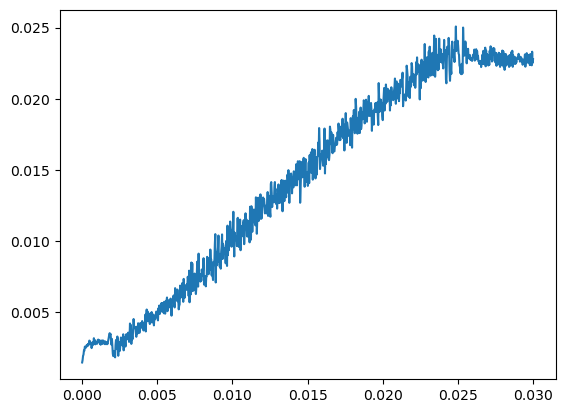

In [19]:
plt.plot(evaluation_points[::period],np.array(avg_cv_means))

# 4c. Use the WHAM method for computing free energies

In [20]:
from FastMBAR import *

In [21]:
# feature_map = torch.vmap(compute_gram_matrix_recentered)

In [49]:
N_samples = 100
N = evaluation_points.shape[0]
period = N // N_samples

In [50]:
cv = []
num_conf = [] 
for j in tqdm(range(N_samples)):
    index = period*j
    mobile = mda.Universe("../data/butane.psf", f"../output/traj_current/short_traj/traj_{j}.dcd", in_memory=True)
    trajectory = torch.permute(torch.Tensor(mobile.trajectory.timeseries(mobile.atoms)).to(device), (1,0,2))
    for i in range(trajectory.shape[0]):
        cv_val = cv_model_2(0.1*trajectory[i,:,:])
        cv.append(cv_val.detach().numpy().flatten())
    # cv.append(cv_data)
    num_conf.append(i+1)

  0%|                                                   | 0/100 [00:00<?, ?it/s]/export/ssule25/miniconda3/envs/ptorch/lib/python3.11/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"
/export/ssule25/miniconda3/envs/ptorch/lib/python3.11/site-packages/MDAnalysis/coordinates/memory.py:535: DeprecationWarning: asel argument to timeseries will be renamed to'atomgroup' in 3.0, see #3911
  warnings.warn(
100%|█████████████████████████████████████████| 100/100 [00:04<00:00, 20.39it/s]


In [51]:
cv = np.array(cv).flatten()
num_conf = np.array(num_conf).flatten()
A = np.zeros((num_conf.shape[0], cv.shape[0]))

In [52]:
for j in tqdm(range(N_samples)): 
    current_point = evaluation_points[j*period] 
    A[j,:] = (1/kbT)*0.5*10000.0*np.abs(current_point - cv)**2

100%|██████████████████████████████████████| 100/100 [00:00<00:00, 69224.36it/s]


In [53]:
## solve MBAR equations using FastMBAR
fastmbar = FastMBAR(energy = A, num_conf = num_conf, cuda=False, verbose = True)
print("Relative free energies: ", fastmbar.F)

                RUNNING THE NEWTON'S METHOD                     

                           * * *                                

                    Tolerance EPS = 1.00000E-12                  

At iterate    0; f= 8.76625E+00; |1/2*Newton_decrement^2|: 1.48058E-31

N_iter   = total number of iterations
N_func   = total number of function and gradient evaluations
F        = final function value 

             * * *     

N_iter    N_func        F
     1         1    8.766247E+00
  F = 8.766247287167 

CONVERGENCE: 1/2*Newton_decrement^2 < EPS
Relative free energies:  [-0.42843014 -0.43155682 -0.43432282 -0.43672814 -0.43877279 -0.44045675
 -0.44178004 -0.44274266 -0.4433446  -0.44358586 -0.44346645 -0.44298637
 -0.44214561 -0.44094417 -0.43938207 -0.43745929 -0.43517584 -0.43253171
 -0.42952692 -0.42616145 -0.42243531 -0.4183485  -0.41390102 -0.40909288
 -0.40392406 -0.39839457 -0.39250442 -0.3862536  -0.37964211 -0.37266995
 -0.36533713 -0.35764364 -0.34958948 -0.34117466 -0.33239

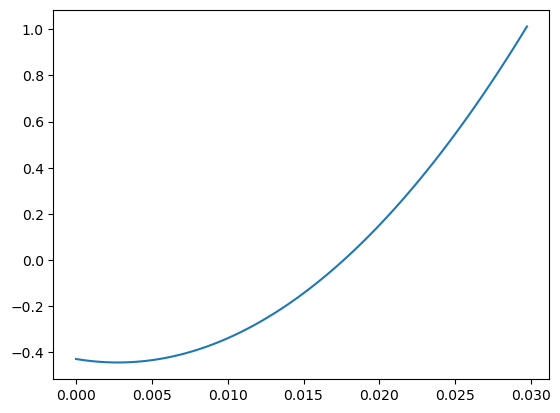

In [54]:
plt.plot(evaluation_points[::period], fastmbar._F)

In [55]:
# interpolation_points = 0.5*(evaluation_points[1:] - evaluation_points[:-1])
interpolation_points = np.linspace(0.0, 0.025, 1000)
width = interpolation_points[1]-interpolation_points[0]
B = np.zeros((interpolation_points.shape[0], cv.shape[0]))
for index in range(interpolation_points.shape[0]):
    pt = interpolation_points[index]
    indicator = np.abs(cv-pt) <= 0.5*width
    B[index, ~indicator] = np.inf

In [56]:
results = fastmbar.calculate_free_energies_of_perturbed_states(B)
PMF = results['F']
PMF_uncertainty = results['F_std']

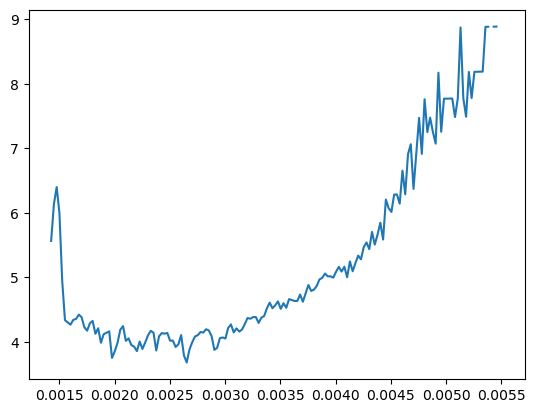

In [57]:
plt.plot(interpolation_points, PMF)

In [41]:
# smooth the free energy profile 
non_infs = np.isinf(PMF)
interpolation_points = interpolation_points[~non_infs]
PMF = PMF[~non_infs]

In [42]:
PMF.shape

(1000,)

# 5. Visualize! 

In [44]:
import scipy

In [45]:
# diffusion_tensors = np.array(M)
data_dir = np.load(f'../output/traj_current/diffusion_tensors_sep12.npz', allow_pickle=True)
diffusion_tensors = data_dir['diffusion_tensors']
evaluation_points = data_dir['evaluation_points']

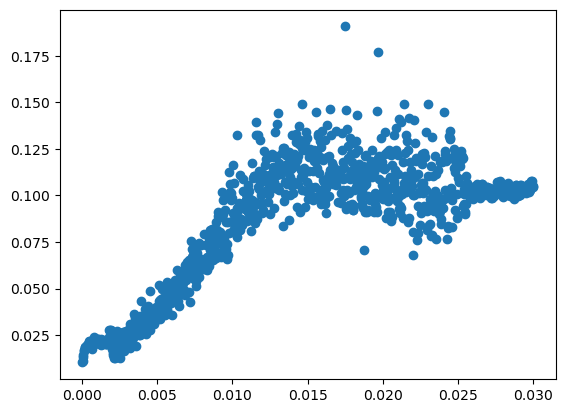

In [46]:
plt.scatter(evaluation_points, diffusion_tensors)

In [47]:
diff_tensor_smooth = scipy.ndimage.gaussian_filter1d(diffusion_tensors, 75)

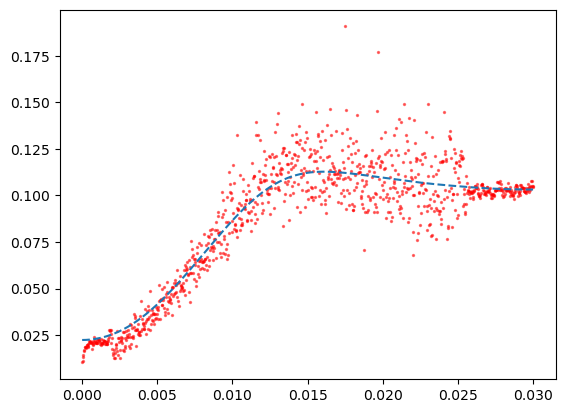

In [48]:
fig, ax = plt.subplots()
ax.plot(evaluation_points, diff_tensor_smooth, linestyle='--')
ax.scatter(evaluation_points, diffusion_tensors, s=2.0, c='r',alpha=0.5)

In [59]:
fname = f"../output/traj_current/diffusion_tensors_smooth_sep12.npz"
np.savez(fname, evaluation_points=evaluation_points, diffusion_tensors=diff_tensor_smooth)

In [61]:
free_energy_smooth = scipy.ndimage.gaussian_filter1d(PMF,50)

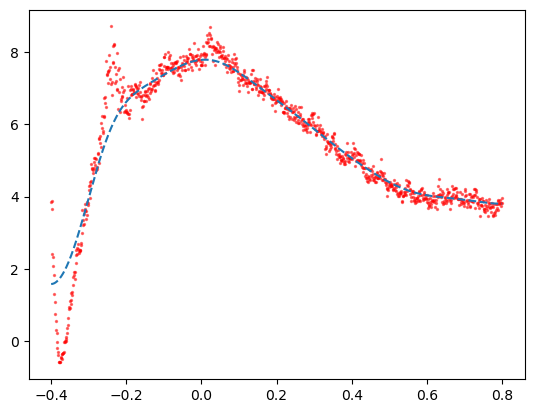

In [62]:
fig, ax = plt.subplots()
ax.plot(evaluation_points, free_energy_smooth, linestyle='--')
ax.scatter(evaluation_points, PMF, s=2.0, c='r',alpha=0.5)

# Save todo

In [63]:
np.savez('/export/ssule25/CV_learning/butane/transition_rate/1D_CV_dnet', \
         evaluation_points = evaluation_points, 
         free_energy = fastmbar.F, 
         diffusion_tensors = diff_tensor_smooth,
         kbT = kbT)

# Plot them ellipses! 

In [ ]:
plot_scale = 1e-3
for i in range(len(M)):
    # if final_angles[i] >= 2.5:
    cov = M[i]
    evals, evecs = np.linalg.eig(cov)
    idx = evals.argsort()[::-1]
    evals = evals[idx]
    evecs = evecs[:, idx]
    t = np.linspace(0, 2*np.pi)
    val = plot_scale*evecs*evals
    x = data[i,:].numpy()
    a = np.dot(val, np.vstack([np.cos(t), np.sin(t)]))
    plt.plot(a[0, :] + x[0], a[1, :] + x[1], linewidth=0.5, c='k')
    plt.scatter(x[0], x[1], color='b', s=1.0)

plt.xlim([0.0,2.0])
plt.ylim([0.0,2.0])

# 4. Save!

In [ ]:
fname = f"../output/traj../output/traj_current/butane_metad_carbon_apr7_difftensor.npz"
data_dic['tensors'] = np.dstack(M)
data_dic['tensor_indices'] = indices
np.save(fname, datadic)